# Imports and config

In [53]:
import os
import pickle
import warnings
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

import config as cfg
import data_processing as dp


warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Data preparation

### Load data

In [13]:
sales = pd.read_csv(cfg.FILENAMES['TRAIN_SALES'])

items = pd.read_csv(cfg.FILENAMES["ITEMS"])

categories = pd.read_csv(cfg.FILENAMES["ITEM_CATEGORIES"])

shops = pd.read_csv(cfg.FILENAMES["SHOPS"])

### Categories features

In [3]:
print(len(categories))
categories.head(2)

84


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [4]:
category_names = list(categories["item_category_name"])
categories["item_category_name_en"] = dp.translate_string_list(category_names)

categories["item_category_name_en_cur"] = dp.process_categories(categories["item_category_name_en"])

main_sub_category_colnames = ["main_category_name", "sub_category_name"]
categories[main_sub_category_colnames] = categories["item_category_name_en_cur"].str.split(" - ", expand=True)
categories.head(2)

,item_category_name,item_category_id,item_category_name_en,item_category_name_en_cur,main_category_name,sub_category_name
0,PC - Гарнитуры/Наушники,0,PC - Headsets / Headphones,Accessories - PC,Accessories,PC
1,Аксессуары - PS2,1,Accessories - PS2,Accessories - PS2,Accessories,PS2


In [5]:
categories = categories[["item_category_id","main_category_name", "sub_category_name"]]
categories.head(1)

,item_category_id,main_category_name,sub_category_name
0,0,Accessories,PC


## Shop features

In [14]:
print(len(shops))
shops.head(2)

60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [16]:
shops["city_rus"] = shops["shop_name"].str.split(" ",expand=True)[0]
shop_names = [x.replace("!","") for x in shops["city_rus"]]
shops["city_name"] = dp.translate_string_list(shop_names)

shops["city_name"] = dp.process_shops(shops["city_name"])
shops.head(2)

,shop_name,shop_id,city_rus,city_name
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,Yakutsk
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,Yakutsk


In [17]:
shops = shops[["shop_id","city_name"]]
shops.head(2)

,shop_id,city_name
0,0,Yakutsk
1,1,Yakutsk


## Items features

No item feature has been computed yet. We'll just use this table to link items with their category.

In [118]:
items = items[["item_id","item_category_id"]]
items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


## Remove train negative values and outliers

In [22]:
print(len(sales))
sales.head(3)

2935849


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


##### Remove negative values

In [26]:
sales_pos = sales.loc[sales["item_cnt_day"]>0]
print(f"From {len(sales)} to {len(sales_pos)}")

From 2935849 to 2928493


##### Remove outliers

In [28]:
sales_pos.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.928493e+06,2.928493e+06,2.928493e+06,2.928493e+06,2.928493e+06
mean,1.456976e+01,3.300295e+01,1.020028e+04,8.894664e+02,1.248337e+00
std,9.422952e+00,1.622543e+01,6.324396e+03,1.727498e+03,2.619586e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.477000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.355000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.569100e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [50]:
print(len(sales_pos[sales_pos["item_cnt_day"]>50]))
sales_pos.loc[sales_pos["item_cnt_day"]>50]

523


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
70814,02.01.2013,0,31,13598,10.000000,64.0
122430,05.02.2013,1,42,2749,1070.698113,53.0
239024,12.03.2013,2,31,6738,699.000000,88.0
244068,08.03.2013,2,31,3320,999.494231,52.0
269148,12.03.2013,2,42,6738,698.994643,56.0
...,...,...,...,...,...,...
2909818,28.10.2015,33,12,11373,0.908714,2169.0
2918659,02.10.2015,33,9,7018,299.000000,67.0
2918694,03.10.2015,33,9,4201,399.000000,62.0
2918705,02.10.2015,33,9,4201,399.000000,110.0


In [57]:
peak_sales_item_ids = set(sales_pos.loc[sales_pos["item_cnt_day"]>50,"item_id"])
print(random.sample(list(items.loc[items["item_id"].isin(peak_sales_item_ids),"item_name"].values), k=10))

['Total War: Rome 2. Имперское издание [PC, русская версия]', 'Билет "ИгроМир 2014" - семейный до 4-х человек вкл. (на один день (отдельно - 3, 4, 5 октября 2014))', 'Prototype 2 [PC, Цифровая версия]', 'Watch_Dogs. Vigilante Edition [PC, русская версия]', 'Орден 1886 [PS4, русская версия]', 'Средиземье: Тени Мордора [PC, Цифровая версия]', 'Grand Theft Auto V [PS3, русские субтитры]', 'StarCraft II: Heart of the Swarm (дополнение) [PC, Jewel, русская версия]', 'Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01)', 'Mortal Kombat X [PS4, русские субтитры]']


Analysis: those peak numbers come from either an error, or the selling of a product on its release date. We should then clip all training daily values to [0,50].

In [58]:
sales_pos.loc[sales["item_cnt_day"]>50, "item_cnt_day"] = 50

In [59]:
sales_pos.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.928493e+06,2.928493e+06,2.928493e+06,2.928493e+06,2.928493e+06
mean,1.456976e+01,3.300295e+01,1.020028e+04,8.894664e+02,1.238134e+00
std,9.422952e+00,1.622543e+01,6.324396e+03,1.727498e+03,1.469850e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.477000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.355000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.569100e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,5.000000e+01


In [61]:
sales_pos.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


## Aggregate sales per month

In [91]:
sales_monthly = (sales_pos.groupby(["date_block_num","shop_id","item_id"])
                            .agg({"date":"first", #we will just extract month and year from it
                                 "item_price": ["mean", "std"],
                                 "item_cnt_day": ["sum","count"]})
                            .reset_index())
sales_monthly.columns = ["date_block_num", "shop_id", "item_id",
                     "random_date", "mean_item_price", "std_item_price",
                      "item_cnt_month", "days_with_sell"]
sales_monthly["std_item_price"] = sales_monthly["std_item_price"].fillna(0)
print(len(sales_monthly))
sales_monthly.head(2)

1608226


,date_block_num,shop_id,item_id,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell
0,0,0,32,03.01.2013,221.0,0.0,6.0,4
1,0,0,33,03.01.2013,347.0,0.0,3.0,3


In [92]:
sales_monthly.describe()

,date_block_num,shop_id,item_id,mean_item_price,std_item_price,item_cnt_month,days_with_sell
count,1.608226e+06,1.608226e+06,1.608226e+06,1.608226e+06,1.608226e+06,1.608226e+06,1.608226e+06
mean,1.466502e+01,3.280798e+01,1.068148e+04,7.901510e+02,8.339656e+00,2.254576e+00,1.820946e+00
std,9.542384e+00,1.653645e+01,6.238856e+03,1.549310e+03,7.358666e+01,7.544538e+00,1.978750e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,0.000000e+00,1.000000e+00,1.000000e+00
25%,6.000000e+00,2.100000e+01,5.046000e+03,1.990000e+02,0.000000e+00,1.000000e+00,1.000000e+00
50%,1.400000e+01,3.100000e+01,1.049700e+04,3.990000e+02,0.000000e+00,1.000000e+00,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.606000e+04,8.949638e+02,0.000000e+00,2.000000e+00,2.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,1.694603e+04,1.150000e+03,3.100000e+01


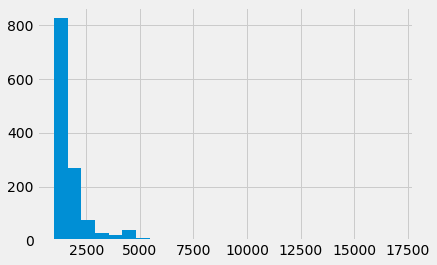

In [93]:
plt.hist(sales_monthly.loc[sales_monthly["std_item_price"]>1000,"std_item_price"], bins=25)
plt.show()

In [106]:
threshold = 100
print(len(sales_monthly.loc[sales_monthly["std_item_price"]<=threshold,]))
print(sales_monthly.loc[sales_monthly["std_item_price"]<=threshold,"item_cnt_month"].mean())
print()
print(len(sales_monthly.loc[sales_monthly["std_item_price"]>threshold,]))
print(sales_monthly.loc[sales_monthly["std_item_price"]>threshold,"item_cnt_month"].mean())

1573330
2.15833423375897

34896
6.593764328289775


In [114]:
threshold = 3500
print(len(sales_monthly.loc[sales_monthly["mean_item_price"]<=threshold,]))
print(sales_monthly.loc[sales_monthly["mean_item_price"]<=threshold,"item_cnt_month"].mean())
print()
print(len(sales_monthly.loc[sales_monthly["mean_item_price"]>threshold,]))
print(sales_monthly.loc[sales_monthly["mean_item_price"]>threshold,"item_cnt_month"].mean())

1578296
2.243511990146335

29930
2.8380220514533914


Analysis: The variation of std(item_price) seems to be an important regressor.

## Add missing combinations

In [134]:
len(sales[sales["item_cnt_day"]==0])

0

There isn't any observation with item_cnt_day = 0. That means that there is no observation whenever some item isn't sold in a shop. We must account for these values.

In [151]:
release_date_items={}

nb_items = len(set(sales_monthly["item_id"]))
for c, i_id in enumerate(set(sales_monthly["item_id"])):
    release_date_items[i_id] = min(sales_monthly.loc[sales_monthly["item_id"]==i_id, "date_block_num"])
    if c%5000==0:
        print(f"{c} / {nb_items} done")
list(release_date_items.items())[:10]

0 / 21804 done
5000 / 21804 done
10000 / 21804 done
15000 / 21804 done
20000 / 21804 done


[(0, 20),
 (1, 15),
 (2, 19),
 (3, 18),
 (4, 20),
 (5, 23),
 (6, 18),
 (7, 23),
 (8, 19),
 (9, 19)]

In [152]:
combinations = []

nb_shops = len(set(sales_monthly["shop_id"]))
for c, s_id in enumerate(set(sales_monthly["shop_id"])):
    for i_id in set(sales_monthly.loc[sales_monthly["shop_id"]==s_id,"item_id"]):
        release_date = release_date_items[i_id]
        for m in range(release_date, 34):
            combinations.append({"shop_id":s_id, "item_id":i_id, "date_block_num":m})
    if (c+1)%10==0:
        print(f"{c+1} / {nb_shops} done")

combinations[:10]

10 / 60 done
20 / 60 done
30 / 60 done
40 / 60 done
50 / 60 done
60 / 60 done


[{'shop_id': 0, 'item_id': 16385, 'date_block_num': 0},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 1},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 2},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 3},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 4},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 5},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 6},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 7},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 8},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 9}]

In [153]:
empty_df = pd.DataFrame(combinations, columns = combinations[0].keys())
print(len(empty_df))
empty_df.head(2)

11158029


,shop_id,item_id,date_block_num
0,0,16385,0
1,0,16385,1


In [154]:
sales_monthly_complete = pd.merge(empty_df, sales_monthly, how="left", on=["shop_id","item_id","date_block_num"])
print(len(sales_monthly_complete))
print(sales_monthly_complete.isnull().sum())
sales_monthly_complete.head(2)

11158029
shop_id                  0
item_id                  0
date_block_num           0
random_date        9549803
mean_item_price    9549803
std_item_price     9549803
item_cnt_month     9549803
days_with_sell     9549803
dtype: int64


,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0


## Merge all tables
sales_monthly, shops, categories and items

In [155]:
sales_monthly_complete.head(1)

,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0


In [156]:
categories.head(1)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0


In [157]:
bigboi = pd.merge(sales_monthly_complete, items, how="left", on="item_id")
bigboi = pd.merge(bigboi, categories, how="left", on="item_category_id")
bigboi = pd.merge(bigboi, shops, how="left", on="shop_id")
print(f"From {len(sales_monthly_complete)} to {len(bigboi)} --> SHOULD NOT CHANGE")
bigboi.head(2)

From 11158029 to 11158029 --> SHOULD NOT CHANGE


,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_category_id,item_category_name,city_name
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,30,Игры PC - Стандартные издания,Yakutsk
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,30,Игры PC - Стандартные издания,Yakutsk


## Fill NA values

In [158]:
bigboi.isnull().sum()

shop_id                     0
item_id                     0
date_block_num              0
random_date           9549803
mean_item_price       9549803
std_item_price        9549803
item_cnt_month        9549803
days_with_sell        9549803
item_category_id            0
item_category_name          0
city_name                   0
dtype: int64

#### item_cnt_month & days_with_sell

item_cnt_month and days_with_sell should be filled with 0

In [159]:
bigboi[["item_cnt_month","days_with_sell"]] = bigboi[["item_cnt_month","days_with_sell"]].fillna(0)

#### mean_item_price and std_item_price

mean_item_price and std_item_price should be filled with a similar value but which one?
- average at a shop x item level
- average at a item x month level
?

##### shop x item level EDA

In [203]:
(bigboi.dropna()
             .groupby(["shop_id","item_id"])
             .agg({"mean_item_price":"std", "std_item_price":"std"})
             .dropna()
             .reset_index()
             .describe())

,shop_id,item_id,mean_item_price,std_item_price
count,277362.000000,277362.000000,277362.000000,277362.000000
mean,32.446914,11199.420335,92.547248,11.201097
std,16.718642,6187.040768,224.228914,58.549466
min,0.000000,1.000000,0.000000,0.000000
25%,19.000000,5797.000000,0.000000,0.000000
50%,31.000000,11240.000000,2.223805,0.000000
75%,47.000000,16468.750000,98.003904,0.000000
max,59.000000,22168.000000,7886.050611,3866.865000


##### item x month

In [202]:
(bigboi.dropna()
             .groupby(["item_id","date_block_num"])
             .agg({"mean_item_price":"std", "std_item_price":"std"})
             .dropna()
             .reset_index()
             .describe())

,item_id,date_block_num,mean_item_price,std_item_price
count,167947.000000,167947.000000,167947.000000,167947.000000
mean,11556.170857,14.474864,27.927520,5.362690
std,6130.550785,9.671751,84.919836,35.405984
min,27.000000,0.000000,0.000000,0.000000
25%,6343.000000,6.000000,0.000000,0.000000
50%,11758.000000,13.000000,0.000000,0.000000
75%,16743.500000,23.000000,30.156127,0.000000
max,22168.000000,33.000000,6830.053294,2653.613888


We observe that the distribution of mean_item_price and std_item_price is more regular on a item x month level. We'll fill NA values according to this granularity.

In [189]:
itemxmonth_mean = (bigboi.dropna()
             .groupby(["item_id","date_block_num"])
             .agg({"mean_item_price":"mean", "std_item_price":"mean"})
             .reset_index())
itemxmonth_mean.head(2)

,item_id,date_block_num,mean_item_price,std_item_price
0,0,20,58.0,0.0
1,1,15,4490.0,0.0


In [215]:
bigboi_filled = pd.merge(bigboi, itemxmonth,
                                    how="left", on=["item_id","date_block_num"], suffixes=["","_fill"])

bigboi_filled["mean_item_price"] = bigboi_filled["mean_item_price"].fillna(bigboi_filled["mean_item_price_fill"])
bigboi_filled["std_item_price"] = bigboi_filled["std_item_price"].fillna(bigboi_filled["std_item_price_fill"])

bigboi_filled = bigboi_filled.drop(["mean_item_price_fill", "std_item_price_fill"], axis=1)

print(bigboi_filled.isnull().sum())
bigboi_filled.head(2)

shop_id                     0
item_id                     0
date_block_num              0
random_date           9549803
mean_item_price       4355967
std_item_price        4355967
item_cnt_month              0
days_with_sell              0
item_category_id            0
item_category_name          0
city_name                   0
dtype: int64


,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_category_id,item_category_name,city_name
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,30,Игры PC - Стандартные издания,Yakutsk
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,30,Игры PC - Стандартные издания,Yakutsk


Now, second step, fill with something more general?
- shop x item ?
- category x month?
- item ?

##### shop x item level

In [216]:
(bigboi_filled.dropna()
             .groupby(["shop_id","item_id"])
             .agg({"mean_item_price":"std", "std_item_price":"std"})
             .dropna()
             .reset_index()
             .describe())

,shop_id,item_id,mean_item_price,std_item_price
count,277362.000000,277362.000000,277362.000000,277362.000000
mean,32.446914,11199.420335,92.547248,11.201097
std,16.718642,6187.040768,224.228914,58.549466
min,0.000000,1.000000,0.000000,0.000000
25%,19.000000,5797.000000,0.000000,0.000000
50%,31.000000,11240.000000,2.223805,0.000000
75%,47.000000,16468.750000,98.003904,0.000000
max,59.000000,22168.000000,7886.050611,3866.865000


##### category x month

In [217]:
(bigboi_filled.dropna()
             .groupby(["item_category_id","date_block_num"])
             .agg({"mean_item_price":"std", "std_item_price":"std"})
             .dropna()
             .reset_index()
             .describe())

,item_category_id,date_block_num,mean_item_price,std_item_price
count,2026.000000,2026.000000,2026.000000,2026.000000
mean,43.246792,16.875617,739.120426,59.021327
std,24.283090,9.710696,885.382164,200.282821
min,2.000000,0.000000,0.000000,0.000000
25%,22.000000,9.000000,169.593957,0.069467
50%,43.000000,17.000000,427.865816,11.271593
75%,65.000000,25.000000,972.109220,42.825464
max,83.000000,33.000000,11270.414843,6446.442930


##### item level

In [218]:
(bigboi_filled.dropna()
             .groupby(["item_id"])
             .agg({"mean_item_price":"std", "std_item_price":"std"})
             .dropna()
             .reset_index()
             .describe())

,item_id,mean_item_price,std_item_price
count,19283.000000,19283.000000,19283.000000
mean,11271.343671,95.377193,10.168821
std,6268.124735,203.426974,49.887337
min,1.000000,0.000000,0.000000
25%,5893.500000,16.037444,0.000000
50%,11340.000000,35.565185,0.000000
75%,16663.500000,96.760138,3.094107
max,22168.000000,5813.875386,2827.273413


We observe that the distribution of mean_item_price and std_item_price is more regular on a item x month level. We'll fill NA values according to this granularity.

In [219]:
item_mean = (bigboi.dropna()
             .groupby(["item_id"])
             .agg({"mean_item_price":"mean", "std_item_price":"mean"})
             .reset_index())
item_mean.head(2)

,item_id,mean_item_price,std_item_price
0,0,58.0,0.0
1,1,4490.0,0.0


In [220]:
bigboi_filled = pd.merge(bigboi_filled, item_mean,
                                    how="left", on=["item_id"], suffixes=["","_fill"])

bigboi_filled["mean_item_price"] = bigboi_filled["mean_item_price"].fillna(bigboi_filled["mean_item_price_fill"])
bigboi_filled["std_item_price"] = bigboi_filled["std_item_price"].fillna(bigboi_filled["std_item_price_fill"])

bigboi_filled = bigboi_filled.drop(["mean_item_price_fill", "std_item_price_fill"], axis=1)

print(bigboi_filled.isnull().sum())
bigboi_filled.head(2)

shop_id                     0
item_id                     0
date_block_num              0
random_date           9549803
mean_item_price             0
std_item_price              0
item_cnt_month              0
days_with_sell              0
item_category_id            0
item_category_name          0
city_name                   0
dtype: int64


,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_category_id,item_category_name,city_name
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,30,Игры PC - Стандартные издания,Yakutsk
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,30,Игры PC - Стандартные издания,Yakutsk


#### random_date

In [224]:
random_dates = bigboi_filled.dropna().groupby("date_block_num").agg({"random_date":"first"}).reset_index()
bigboi_filled = pd.merge(bigboi_filled, random_dates, how="left", on="date_block_num", suffixes=["","_fill"])
bigboi_filled["random_date"] = bigboi_filled["random_date"].fillna(bigboi_filled_r["random_date_fill"])

print(bigboi_filled.isnull().sum())
bigboi_filled.head(2)

shop_id               0
item_id               0
date_block_num        0
random_date           0
mean_item_price       0
std_item_price        0
item_cnt_month        0
days_with_sell        0
item_category_id      0
item_category_name    0
city_name             0
random_date_fill      0
dtype: int64


,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_category_id,item_category_name,city_name,random_date_fill
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,30,Игры PC - Стандартные издания,Yakutsk,20.01.2013
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,30,Игры PC - Стандартные издания,Yakutsk,25.02.2013
